# Usupervised classification of philosophical genres

This notebook is a part of work being done for the [Trace of Theory project](https://github.com/htrc/ACS-TT), a collaboration between researchers of [NovelTM](http://novel-tm.ca/) and the HathiTrust Research Center ([HTRC](https://www.hathitrust.org/)).

Here, we'll use unsupervised techniques to identify clusters of similar texts within a corpus of about 3,200 philosophical texts (identified from the HathiTrust public domain corpus using keyword frequencies in prior work). The idea is to look for something like philsophical "genres" and to compare the computational results to human labels. Our features will mix word-count data with measures of form and with textual metadata, so that we're examining not just subject matter, but also style and (minimal) context.

The work below is almost exclusively about methods. There's not a lot of analysis, and the notebook ends with suggestions for things to try, rather than conclusions about philosophical genre.

## Roadmap

* Download feature data for the 3,200 philosophical texts from the HathiTrust Research Center
* Parse feature data
* Calculate other features derived from the same sources
* Reduce the dimensions of the feature space in order to have some hope of clustering the texts
* Perform _k_-means and DBSCAN clustering on the dimension-reduced features
* Visualize the clustering output alongside the human labels


## Imports


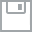
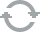
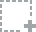
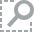
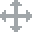
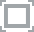
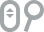
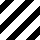
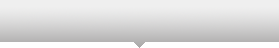
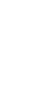
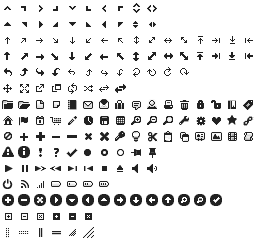
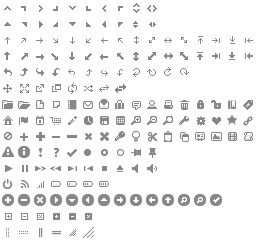
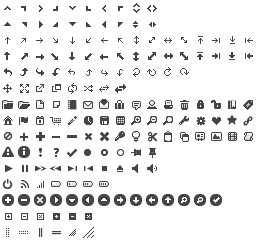
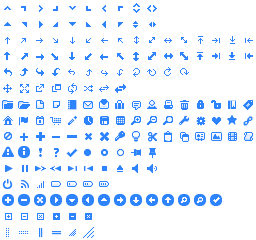
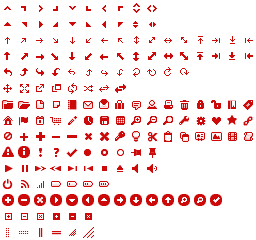
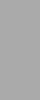
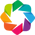
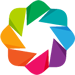

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Data libraries
import pandas as pd
from nltk.corpus.reader import PlaintextCorpusReader
from nltk.corpus import cmudict
import nltk
from collections import defaultdict
import bz2
import json
import os
import subprocess

# Machine learning and math libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns  # Note that seaborn >= 0.6.0 is required for some plots
from bokeh.charts import Scatter, output_notebook, show
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.plotting import figure
from bokeh.palettes import Spectral5, Spectral6, Spectral7

# Set up plotting
sns.set_context('talk')
sns.set_style('darkgrid')
plt.figure(figsize=(8, 6))
basecolor = 'steelblue'
% matplotlib inline
output_notebook()

## Get input files

In previous work, Geoffrey Rockwell and others used a [list of philosophical keywords](https://github.com/htrc/ACS-TT/blob/master/data/philosophy/keywords.txt) to identify texts from the HTRC corpus that were likely to be philosophical. We use the resulting list of [3,231 philosophical texts](https://github.com/htrc/ACS-TT/blob/master/data/philosophy/over1%20freqsort%20test.csv). From those we just want basic metadata and HTIDs in order to download the corresponding [HTRC derived feature](https://sharc.hathitrust.org/features) files. Note that we're using a 'clean,' UTF-8 encoded version of the list of texts; the original list causes problems down the line.

In [2]:
philo_list = pd.read_csv('../../data/philosophy/over1 freqsort test clean.csv')
philo_list = philo_list[['Discipline', 'ID', 'Title', 'Author', 'Year', 'Relative Freq']]
philo_list.columns = ['label', 'htid', 'title', 'auth', 'year', 'freq']
philo_list.head()

label                      htid  \
0  theo  uc2.ark:/13960/t4jm2cj7x   
1  theo  uc2.ark:/13960/t6j105c55   
2  theo  uc2.ark:/13960/t2f76gd3p   
3    ed  loc.ark:/13960/t97664b0x   
4    ed  uc2.ark:/13960/t18k7739n   

                                               title  \
0  Will higher of God and free will of life made ...   
1  Man, the life free, by the authors of "Thought...   
2  Thought for help, from those who know men's ne...   
3  The metaphysics of education. [By] Arthur C Fl...   
4  Syllabus of a course on the philosophy of educ...   

                                    auth  year      freq  
0  Comstock, William Charles, 1847-1924.  1914  0.262600  
1  Comstock, William Charles, 1847-1924.  1916  0.257248  
2  Comstock, William Charles, 1847-1924.  1913  0.218047  
3                 Fleshman, Arthur Cary.  1914  0.174253  
4      MacVannel, John Angus, 1871-1915.  1904  0.169895

In the data, 'freq' is the relative frequency of philosophical keywords. The field for 'disc' (here renamed to 'label') is a human-applied label for the type of philosophy in each volume. The labels are distributed like so:

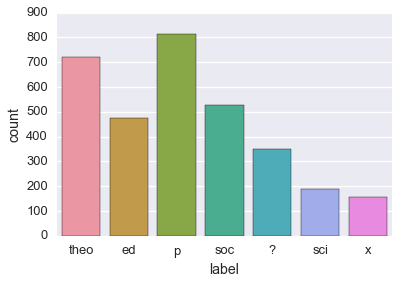

In [3]:
sns.countplot(x='label', data=philo_list)

OK, so really only about 25% of the 'philosophical' texts are labeled philosophy proper. We'll bear this in mind. Now we want to download the HTRC derived feature files for those 3,231 volumes. To do that, we'll generate a list with full pairtree file paths, then use `rsync` to bring them over to local storage. See the [HTRC documentation](https://sharc.hathitrust.org/features#downloads) for details concerning their storage structure.

Note that HTIDs need to be convernted to filesystem-safe versions by converting instances of ':' to '+' and '/' to '+'.

In [4]:
# Convert HTIDs to filesystem-safe versions for rsync
philo_list['file'] = philo_list['htid'].str.replace(':', '+')
philo_list['file'] = philo_list['file'].str.replace('/', '=')
philo_list = philo_list[['label', 'title', 'auth', 'year', 'freq', 'htid', 'file']]
philo_list.head()

label                                              title  \
0  theo  Will higher of God and free will of life made ...   
1  theo  Man, the life free, by the authors of "Thought...   
2  theo  Thought for help, from those who know men's ne...   
3    ed  The metaphysics of education. [By] Arthur C Fl...   
4    ed  Syllabus of a course on the philosophy of educ...   

                                    auth  year      freq  \
0  Comstock, William Charles, 1847-1924.  1914  0.262600   
1  Comstock, William Charles, 1847-1924.  1916  0.257248   
2  Comstock, William Charles, 1847-1924.  1913  0.218047   
3                 Fleshman, Arthur Cary.  1914  0.174253   
4      MacVannel, John Angus, 1871-1915.  1904  0.169895   

                       htid                      file  
0  uc2.ark:/13960/t4jm2cj7x  uc2.ark+=13960=t4jm2cj7x  
1  uc2.ark:/13960/t6j105c55  uc2.ark+=13960=t6j105c55  
2  uc2.ark:/13960/t2f76gd3p  uc2.ark+=13960=t2f76gd3p  
3  loc.ark:/13960/t97664b0x  loc.ark+=13960=t97664b0x  
4  uc2.ark:/13960/t18k7739n  uc2.ark+=13960=t18k7739n

Now parse the file-safe HTIDs into pairtree paths (as used by the HTRC). In a different world, I suppose we'd use a pairtree library rather than handling this from scratch ...

In [5]:
# A function to convert HTIDs to pairtree paths
def htid2ptpath(htid, prefix='basic', suffix='.basic.json.bz2'):
    '''A function to convert HathiTrust file IDs to pairtree paths.
        Takes an input HTID, an optional path prefix to be prepended to the
        generated path, and an optional suffix (like '.basic.json.bz2').
        Returns a string representing the HTRC pairtree path.'''
    inst, ptid = htid.split(sep='.', maxsplit=1)
    pt_segments = (len(ptid)//2) + 1
    path = prefix + '/' + inst + '/' + 'pairtree_root' + '/'
    for i in range(pt_segments):
        try:
            path += ptid[i*2:(i+1)*2] + '/'
        except:
            path += ptid[i*2:i*2+1] + '/'
    return path[0:-1] + ptid + '/' + inst + '.' + ptid + suffix

In [6]:
philo_list['path'] = philo_list['file'].apply(htid2ptpath)
philo_list.head()

label                                              title  \
0  theo  Will higher of God and free will of life made ...   
1  theo  Man, the life free, by the authors of "Thought...   
2  theo  Thought for help, from those who know men's ne...   
3    ed  The metaphysics of education. [By] Arthur C Fl...   
4    ed  Syllabus of a course on the philosophy of educ...   

                                    auth  year      freq  \
0  Comstock, William Charles, 1847-1924.  1914  0.262600   
1  Comstock, William Charles, 1847-1924.  1916  0.257248   
2  Comstock, William Charles, 1847-1924.  1913  0.218047   
3                 Fleshman, Arthur Cary.  1914  0.174253   
4      MacVannel, John Angus, 1871-1915.  1904  0.169895   

                       htid                      file  \
0  uc2.ark:/13960/t4jm2cj7x  uc2.ark+=13960=t4jm2cj7x   
1  uc2.ark:/13960/t6j105c55  uc2.ark+=13960=t6j105c55   
2  uc2.ark:/13960/t2f76gd3p  uc2.ark+=13960=t2f76gd3p   
3  loc.ark:/13960/t97664b0x  loc.ark+=13960=t97664b0x   
4  uc2.ark:/13960/t18k7739n  uc2.ark+=13960=t18k7739n   

                                                path  
0  basic/uc2/pairtree_root/ar/k+/=1/39/60/=t/4j/m...  
1  basic/uc2/pairtree_root/ar/k+/=1/39/60/=t/6j/1...  
2  basic/uc2/pairtree_root/ar/k+/=1/39/60/=t/2f/7...  
3  basic/loc/pairtree_root/ar/k+/=1/39/60/=t/97/6...  
4  basic/uc2/pairtree_root/ar/k+/=1/39/60/=t/18/k...

In [7]:
# Write out list of feature files for use by rsync
philo_list['path'].to_csv('../../data/philosophy/3k_paths.csv', index=False)

Call `rsync` to retrieve the feature files from the HTRC. Note that a few files (32 out of 3,231) will fail. One could examine these by printing the `failures` list.

In [8]:
# Call rsync to download the feature files
data_dir   = os.path.expanduser('~/Documents/Code/ACS-TT/data/philosophy')
rsync_list = os.path.join(data_dir, '3k_paths.csv')
rsync_dir  = os.path.join(data_dir, '3k_features')

failures = []

try:
    subprocess.check_output(['rsync', '-av', '--files-from', rsync_list, 'data.sharc.hathitrust.org::pd-features', rsync_dir],
                           stderr=subprocess.STDOUT, universal_newlines=True, )
except subprocess.CalledProcessError as e:
    failures.append(e.output)

If you examine the list of `failures`, you can see that some of the feature files are missing. But not many. We'll deal with this later by excluding the missing files.

## Extract features from texts

We'd like to use Peter Organisciak's [htrc-feature-reader](https://github.com/organisciak/htrc-feature-reader) library to extract data from the feature files, but it isn't working at the moment. Switch to that library in the future, since it's easier than the hand-coding below.

In the end, we want to extract and/or compute the following features for each volume:

* TF-IDF scores for the top, say, 5,000 words. Then reduce dimensionality for these features via PCA
* Length of volume in words
* Date of publication
* Reading level score, which requires knowing average sentence length in words and average syllables per word
* Diction score, as measured by proportion of tokens that entered the English language before 1150. Higher values here correspond to "lower" diction (i.e., more Germanic, less Latinate).
* Fraction of tokens that are proper nouns (how character-driven is the text?)
* Fraction of tokens that are verbs (how action-oriented is the text?)

The idea isn't that these are the only -- or even necessarily the correct -- features to use. But they combine content analysis with formal and metadata features is a way that may be illustrative.

First, make a pass over all the files, eliminating from the data frame any that did not download from HTRC. This isn't super efficient, but it's easier than keeping track while we're also calculating features in the next step.

In [9]:
# Get full local paths to feature files
paths = [os.path.join(rsync_dir, i) for i in philo_list['path']]

good = []
for i in paths:
    if os.path.isfile(i):
        good.append(True)
    else:
        good.append(False)
good = pd.Series(good)
philo_list = philo_list.drop(good[good == False].index)
philo_list['htid'].count()

3199

Note that we've gone from 3231 entries to 3199; there were 32 feature files that failed to download from HTRC. That's good enough for now.

In [10]:
# Define functions to look up word era (for diction scores) and syllables per word

# Syllables per word
d = cmudict.dict()
def nsyl(word):
    '''Takes a string. Returns the number fo syllables in that string.'''
    return [len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]]

# Word era. Etymolgy data from Ted Underwood and Jordan Sellers.
etym = pd.read_csv('../../data/philosophy/Etymologies.txt', sep='\t', names=['word', 'date', 'count'])
pre = etym[(etym['date'] > 1) & (etym['date'] < 1150)]['word']
post = etym[etym['date'] >= 1150]['word']
pre = set(pre)
post = set(post)
print('Pre-1150 words: ', len(pre))
print('Post-1150 words:', len(post))

def wordEra(word, prelist, postlist):
    '''
    Takes string 'word' and lists of pre- and post-era words. 
    Returns 0 if word in prelist, 1 if word in postlist, else raises error.'''
    if word in prelist:
        return 0
    elif word in postlist:
        return 1
    else:
        raise ValueError(word, 'in neither list')

Pre-1150 words:  2211
Post-1150 words: 7324


Define a function that calculates the desired volume-level features from an HTRC compressed feature file.

In [11]:
# A function to do all the heavy lifting.
def get_feature_data_raw(filename):
    '''Takes the name of an HTRC extracted feature file. Assumes file is compressed with bz2.
        Returns a bunch of features:
            htid,          # The HathiTrust ID of the volume
            words,         # Count of word tokens (total)
            reading_level, # Calculated reading level score
            pre_frac,      # Fraction of recognized tokens that entered English before 1150
            verb_frac,     # Fraction of tokens that are verbs (any tense)
            np_frac,       # Fraction of tokens that are proper nouns
            text_blob      # Bag of words from the volume as a whole (for later processing)
    '''
    with bz2.open(filename, 'rt', encoding='utf-8') as b:
        data = json.load(b)
    
        words = 0
        sentences = 0
        syllables = 0
        syl_words = 0
        pre1150 = 0
        post1150 = 0
        proper_nouns = 0
        verbs = 0
        vol_tokens = defaultdict(int)
        nnp_set = ('NNP', 'NNPS') # Tags for proper nouns
        vb_set = ('VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ') # Tags for verbs
        ignore_set = ('.', 'CD') # Token types to ignore (punctuation and numbers)
        text_blob = ''
    
        for page in data['features']['pages']: # page is a dict of page-level data
            words += int(page['body']['tokenCount'])
            sentences += int(page['body']['sentenceCount'])
            for token in page['body']['tokenPosCount']: # token is a word in page body
                for tag in page['body']['tokenPosCount'][token].keys():
                    if tag in nnp_set:
                        proper_nouns += int(page['body']['tokenPosCount'][token][tag])
                    if tag in vb_set:
                        verbs += int(page['body']['tokenPosCount'][token][tag])
                    if tag not in ignore_set:
                        vol_tokens[token.lower()] += int(page['body']['tokenPosCount'][token][tag])
    
        for token in vol_tokens:
            occurs = vol_tokens[token]
            try:
                era = wordEra(token, pre, post) # Look up word era
                if era:
                    post1150 += occurs
                else:
                    pre1150 += occurs
            except:
                pass
            try:
                syl = nsyl(token)[0] # Look up syllables in this word
                syllables += syl*occurs
                syl_words += occurs
            except:
                pass
            text_blob += (token + ' ')*occurs

        # Calculate values to return
        reading_level = 0.39*(words/sentences) + 11.8*(syllables/syl_words) - 15.59
        pre_frac = pre1150/(pre1150+post1150)
        verb_frac = verbs/words
        np_frac = proper_nouns/words
        htid = data['id'].replace(':', '+').replace('/', '=')
            
        return (htid, words, reading_level, pre_frac, verb_frac, np_frac, text_blob)

### Extract derived feature data from HTRC files
This is slow; it takes about half an hour on my laptop.

In [12]:
# Iterate over feature files to calculate derived features
# New list of paths, now excluding the feature files that did not download
paths = [os.path.join(rsync_dir, i) for i in philo_list['path']]

processed = 0
word_counts = []
reading_levels = []
pre_fractions = []
verb_fractions = []
np_fractions = []
text_blob_dir = '../../data/philosophy/3k_text_blobs' # Directory to store bags of words

if not os.path.exists(text_blob_dir):
    os.makedirs(text_blob_dir)

# Iterate over all the feature files and store results. Slow (tens of minutes).
for fn in paths:
    htid, wc, rl, pf, vf, nf, blob = get_feature_data_raw(fn)
    word_counts.append(wc)
    reading_levels.append(rl)
    pre_fractions.append(pf)
    verb_fractions.append(vf)
    np_fractions.append(nf)
    f = open(os.path.join(text_blob_dir, htid), 'w')
    f.write(blob)
    f.close()
    processed += 1
    if (processed)%100 == 0:
        print(processed, 'files complete')

print('Total files processed:', processed)

100 files complete
200 files complete
300 files complete
400 files complete
500 files complete
600 files complete
700 files complete
800 files complete
900 files complete
1000 files complete
1100 files complete
1200 files complete
1300 files complete
1400 files complete
1500 files complete
1600 files complete
1700 files complete
1800 files complete
1900 files complete
2000 files complete
2100 files complete
2200 files complete
2300 files complete
2400 files complete
2500 files complete
2600 files complete
2700 files complete
2800 files complete
2900 files complete
3000 files complete
3100 files complete
Total files processed: 3199


In [13]:
# Add newly calculated features to data frame
philo_list['words'] = pd.Series(word_counts)
philo_list['read'] = pd.Series(reading_levels)
philo_list['pre'] = pd.Series(pre_fractions)
philo_list['verb'] = pd.Series(verb_fractions)
philo_list['nounp'] = pd.Series(np_fractions)

In [14]:
# Calculating features above is slow work; write to csv to avoid rerunning in future.
philo_list.to_csv('../../data/philosophy/3k_df_mid.csv', sep='\t')

In [15]:
# Vectorize TF-IDF data for the texts. Slow (minutes).
blob_dir = '../../data/philosophy/3k_text_blobs/'
corpus = PlaintextCorpusReader(blob_dir, '\w.*', encoding='latin-1')
vectorizer = TfidfVectorizer(use_idf=True,
                             stop_words=nltk.corpus.stopwords.words('english'),
                             max_features=5000,
                             decode_error='ignore')
sorted_fileids = [fileid for fileid in sorted(corpus.fileids())]
%time tfidf_data = vectorizer.fit_transform([corpus.raw(fileid) for fileid in sorted_fileids])

CPU times: user 13min 30s, sys: 24.4 s, total: 13min 54s
Wall time: 14min 15s


In [16]:
# 3199 documents x 5000 terms
tfidf_data.shape

(3199, 5000)

In [17]:
# Run PCA on tfidf data to reduce dimensionality
components = 10 # Number of principal components to fit
pca = PCA(n_components=components)

%time tfidf_pca = pca.fit_transform(tfidf_data.toarray())

CPU times: user 1min 38s, sys: 2.39 s, total: 1min 40s
Wall time: 55 s


In [18]:
# Get loadings for later use
pca_loadings = pca.components_
print(pca_loadings.shape)

# How much variance do we capture?
for i in range(1,components+1):
    pctvar = sum(pca.explained_variance_ratio_[0:i])
    print("Cumulative variance explained:", pctvar, ", PC", i)

(10, 5000)
Cumulative variance explained: 0.0651931023337 , PC 1
Cumulative variance explained: 0.115006561991 , PC 2
Cumulative variance explained: 0.147654216865 , PC 3
Cumulative variance explained: 0.176846409273 , PC 4
Cumulative variance explained: 0.197697797643 , PC 5
Cumulative variance explained: 0.217592191473 , PC 6
Cumulative variance explained: 0.233724163117 , PC 7
Cumulative variance explained: 0.247953777425 , PC 8
Cumulative variance explained: 0.260202397093 , PC 9
Cumulative variance explained: 0.271562051642 , PC 10


OK, we capture 27.2% of the observed variance in 5,000 tfidf terms with these 10 components. Is this good? Well, on one hand, we loose almost 3/4 of the underlying word-frequency information. On the other hand, we've reduced our dimensionality by 99.8% (from 5,000 dimensions to 10) and still retained more than a quarter of the info, so ...

In [19]:
# Convert dimension-reduced tfidf matrix to pandas dataframe, indexed by file name
col_labels = ['PC'+str(i) for i in range(10)]
tfidf_df = pd.DataFrame(tfidf_pca, index=sorted_fileids, columns=col_labels)
tfidf_df.index.rename('file', inplace=True)
tfidf_df.head()

PC0       PC1       PC2       PC3       PC4  \
file                                                                         
loc.ark+=13960=t0000w06f  0.279257 -0.111199  0.249977  0.037709 -0.112982   
loc.ark+=13960=t00z7sr8b  0.355015  0.093406  0.357870 -0.017597 -0.040248   
loc.ark+=13960=t01z4ks70  0.195769 -0.247471 -0.192854  0.026626  0.022854   
loc.ark+=13960=t02z20g9f  0.168137 -0.198680 -0.202354 -0.042993 -0.058926   
loc.ark+=13960=t03x8r043  0.159177 -0.048058 -0.048808  0.275640 -0.009422   

                               PC5       PC6       PC7       PC8       PC9  
file                                                                        
loc.ark+=13960=t0000w06f  0.084271 -0.203856  0.065482 -0.053169  0.053021  
loc.ark+=13960=t00z7sr8b  0.161549 -0.019496 -0.034174  0.034889  0.002782  
loc.ark+=13960=t01z4ks70 -0.019168  0.172995  0.162775  0.112626 -0.023345  
loc.ark+=13960=t02z20g9f  0.044049  0.124556  0.089082  0.052765  0.006583  
loc.ark+=13960=t03x8r043 -0.104153 -0.018228 -0.096360 -0.093210 -0.010319

In [20]:
# Create a new data frame from original philo_list with escaped htid 
#   as index (to match the index on tfidf data)
philo = philo_list.set_index('file')
philo.sort_index(inplace=True)

In [21]:
# Merge the two data frames
philo = philo.merge(tfidf_df, left_index=True, right_index=True)

In [22]:
# Drop the volumes for which we lack one or more pieces of data
philo = philo.dropna()

In [23]:
# Write out the data for later reuse
philo.to_csv('../../data/philosophy/3k_df_fin.csv', sep='\t')
pca_loadings_df = pd.DataFrame(pca_loadings)
pca_loadings_df.to_csv('../../data/philosophy/3k_loadings.csv', sep='\t')

In [24]:
# Some quick summary info about the final, complete data frame 
philo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3165 entries, loc.ark+=13960=t0000w06f to yale.39002098631758
Data columns (total 22 columns):
label    3165 non-null object
title    3165 non-null object
auth     3165 non-null object
year     3165 non-null float64
freq     3165 non-null float64
htid     3165 non-null object
path     3165 non-null object
words    3165 non-null float64
read     3165 non-null float64
pre      3165 non-null float64
verb     3165 non-null float64
nounp    3165 non-null float64
PC0      3165 non-null float64
PC1      3165 non-null float64
PC2      3165 non-null float64
PC3      3165 non-null float64
PC4      3165 non-null float64
PC5      3165 non-null float64
PC6      3165 non-null float64
PC7      3165 non-null float64
PC8      3165 non-null float64
PC9      3165 non-null float64
dtypes: float64(17), object(5)
memory usage: 568.7+ KB


### Some quick vis for reference

Plot histograms of corpus data.

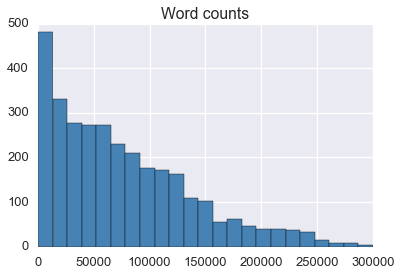

In [25]:
words_fig = plt.hist(list(philo['words']), color=basecolor, bins=np.linspace(0,300000,24))
plt.title('Word counts')

Hmm ... that's a bit worrying. What's with all the short books? Take a closer look ...

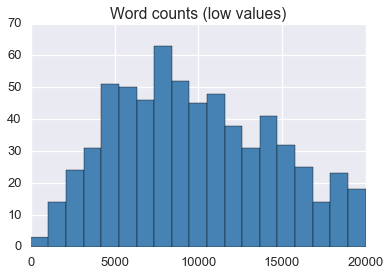

In [26]:
words_fig2 = plt.hist(list(philo['words']), color=basecolor, bins=np.linspace(0,20000,20))
plt.title('Word counts (low values)')

Meh, guess there are just a lot of pamphlets in the dataset. Moving on.

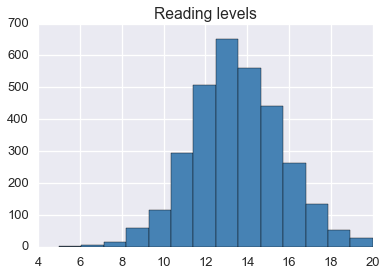

In [27]:
read_fig = plt.hist(list(philo['read']), color=basecolor, bins=np.linspace(5,20,15))
plt.title('Reading levels')

Reading levels more or less normally distributed. These are not easy-reading books.

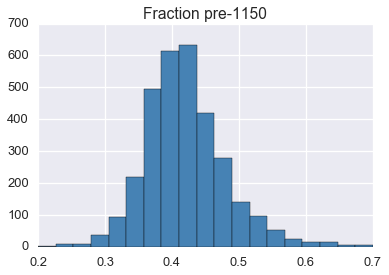

In [28]:
pre_fig = plt.hist(list(philo['pre']), color=basecolor, bins=np.linspace(0.2,0.7,20))
plt.title('Fraction pre-1150')

Relatively normal distribution of diction scores.

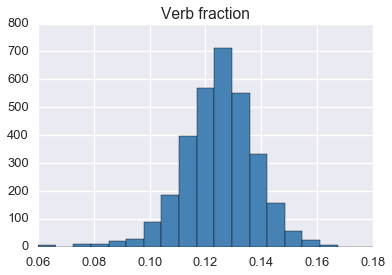

In [29]:
verb_fig = plt.hist(list(philo['verb']), color=basecolor, bins=np.linspace(0.06,0.18,20))
plt.title('Verb fraction')

Ditto verb fractions.

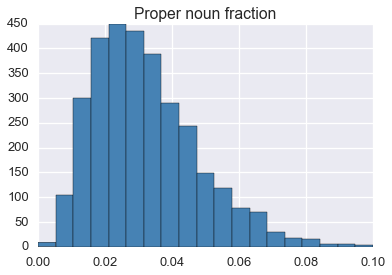

In [30]:
nounp_fig = plt.hist(list(philo['nounp']), color=basecolor, bins=np.linspace(0,0.1,20))
plt.title('Proper noun fraction')

Not at all normal distribution of proper nouns; long tail into high values.

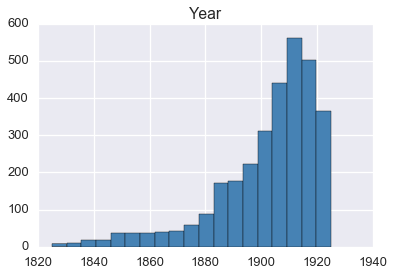

In [31]:
year_fig = plt.hist(list(philo['year']), color=basecolor, bins=np.linspace(1825,1925,20))
plt.title('Year')

Books skew heavily toward recent publication. All data is drawn from the HathiTrust public domain corpus, so there's nothing after 1923, hence the wall at 1920.

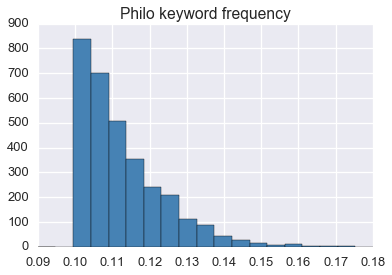

In [32]:
freq_fig = plt.hist(list(philo['freq']), color=basecolor, bins=np.linspace(0.09,0.18,20))
plt.title('Philo keyword frequency')

Looks like there was an explicit cutoff in the keyword-based selection process at philosophical word frequency = 0.10. Result is the clipped high side of what I presume is an underlying normal distribution of these terms in the full corpus. OK, no problem.

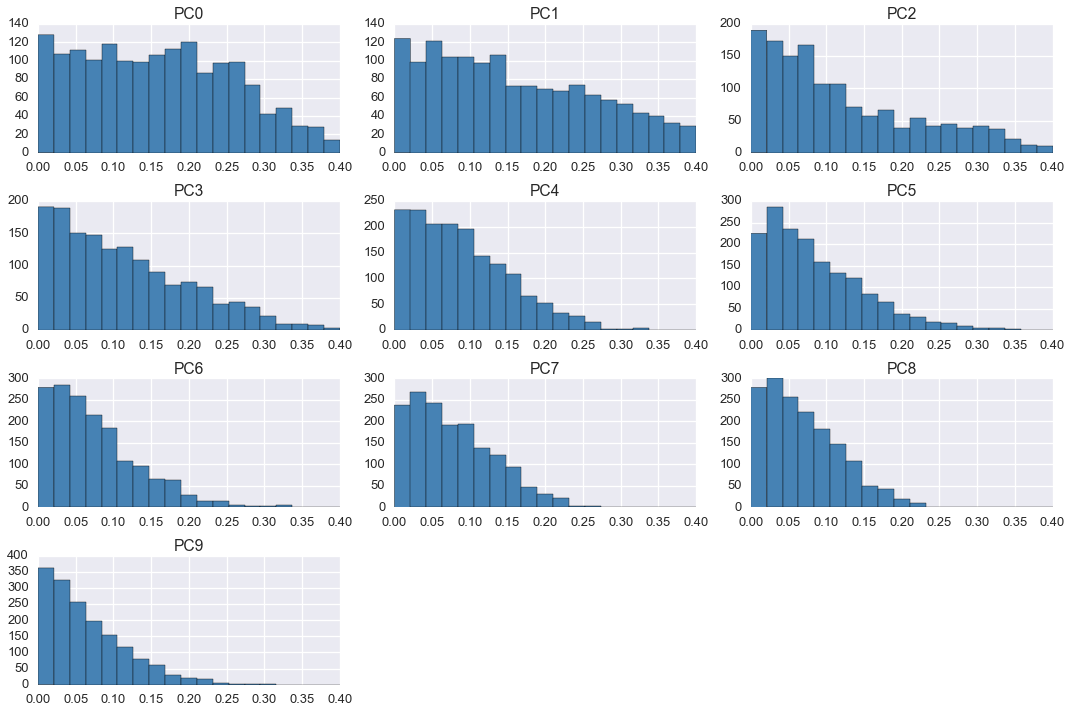

In [33]:
# And the TFIDF PCAs
pca_fig = plt.figure(figsize=(15,10))
for i in range(10):
    component = 'PC'+str(i)
    figno = i+1
    subfig = pca_fig.add_subplot(4,3,figno)
    subfig.hist(list(philo[component]), color=basecolor, bins=np.linspace(0,0.4,20))
    subfig.set_title(component)
pca_fig.tight_layout()

OK, all our data is in place, though it's not (yet) normalized. Time to do some clustering and visualization.

## Clustering

We'll try both _k_-means and DBSCAN ...

In [34]:
# Extract data for scikit-learn and normalize
# Keep list of human labels
philo_labels = list(philo['label'])
# Drop columns not used for analysis
philo_data = philo.drop(['label', 'title', 'auth', 'htid', 'path'], axis=1)
# Convert to numpy array
philo_data = philo_data.as_matrix()
# Set up scaler
scaler = StandardScaler()
# Normalize data
philo_data = scaler.fit_transform(philo_data)
print(np.mean(philo_data), np.std(philo_data))
print(philo_data.shape)

4.57187798755e-16 1.0
(3165, 17)


Note that the normalized mean is zero and standard deviation is 1. There are 3165 documents, each having 17 features (10 word-based PCs and 7 form/metadata features).

In [35]:
# k-means
k = 7 # Matches number of human labels
km = KMeans(n_clusters=k)
%time km.fit(philo_data)

CPU times: user 1.14 s, sys: 18.7 ms, total: 1.15 s
Wall time: 596 ms


KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=7, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

Note, FWIW, that _k_-means clustering is very fast. DBSCAN is slower, but not radically so. The slow steps in all this work, as you'll already have seen if you've run the code yourself, involve acquiring and wrangling the data, not working with it once it's nicely ingested.

In [36]:
# Examine the labels for k-means
k_labels = km.labels_.tolist()
k_labels = pd.Series(k_labels, index=philo.index, name='k_label')
k_labels.value_counts()

3    941
1    602
0    468
4    453
5    381
6    263
2     57
Name: k_label, dtype: int64

In [37]:
# Same thing for DBSCAN
db = DBSCAN(eps=2.44, min_samples=10)
%time db.fit(philo_data)
d_labels = db.labels_.tolist()
d_labels = pd.Series(d_labels, index=philo.index, name='d_label')
d_labels.value_counts()

CPU times: user 962 ms, sys: 14.6 ms, total: 977 ms
Wall time: 993 ms


-1    1889
 0    1162
 1      58
 4      17
 5      12
 3      12
 6      10
 2       5
Name: d_label, dtype: int64

Cluster -1 in DBSCAN output means 'Other', i.e., noise. This suggests one of two things: either we don't have the right value of epsilon or our textual data is insufficiently dense in the feature space.

Back of the envelope calculation re: density ... We're working in 17 dimensions, and we have 3,165 texts. Assume each dimension can take only binary values, which is to say that it divides the possible clustering space in half. That means we have $2^{17}$ = 131,072 logical bins into which to place the texts. So, ummm, no wonder we don't really see good clustering over just 3,165 texts. The chance of seeing even two or three texts in the same bin is pretty small.

This is an obvious area for improvement. What would be an appropriate number of dimensions in whch to cluster c. 3,000 points? Well, we want more bins than clusters, so that we don't just end up with unrelated things being stuffed into the same bin for lack of alternatives. But we don't want so many bins that none of them has any significant number of texts. Maybe, say, 300-ish bins, for an average of 10 items per bin? $2^8$ = 256, which is in the right ballpark.

The thing to do, then, would be to use PCA (or another dimensional reduction technique, like MDS or _t_-SNE) to bring our dimensions down to 8. Not doing this here, but the idea is exactly the same as what we did to reduce the 5,000 TF-IDF features to 10, or how we reduce the current 17 dimensions to 2 for plotting below.

In [38]:
# Add cluster labels to data frame for plotting
philo['k_label'] = k_labels
philo['d_label'] = d_labels

## Plots

### Human labels

Recall the distribution of human labels in our data. Remember that 'x' and '?' are junk or miscellaneous categories; we don't expect them to correspond to known-good philosophical subgenres.

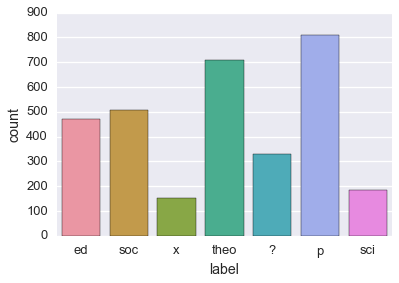

In [39]:
# Human labels
sns.countplot(x='label', data=philo)

### k-means

**NB.** Labels aren't correlated with human labels, so this IS NOT a plot of performance vs. humans. Don't read anything into the colors or ording of clusters.

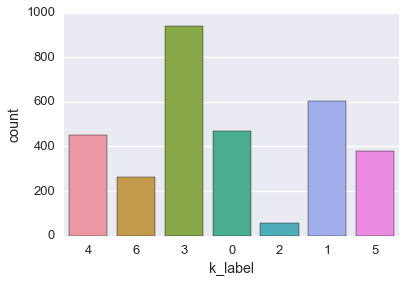

In [40]:
# k-means
sns.countplot(x='k_label', data=philo)

### DBSCAN

Ditto re: lack of correlation here. Note that cluster `-1` means "no cluster" or "outlier."

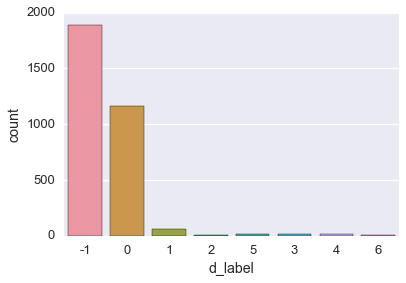

In [41]:
sns.countplot(x='d_label', data=philo)

### Plot in PCA space to see the clusters

In [42]:
# Reduce philo_data to two dimensions for plotting
dim = 2
pca_plot = PCA(n_components=dim)

%time philo_data_plot = pca_plot.fit_transform(philo_data)

CPU times: user 13 ms, sys: 3.25 ms, total: 16.2 ms
Wall time: 15.3 ms


In [43]:
# Add the PCs to data frame for easier plotting
philo['P1'] = philo_data_plot[:,0]
philo['P2'] = philo_data_plot[:,1]

### Human labels

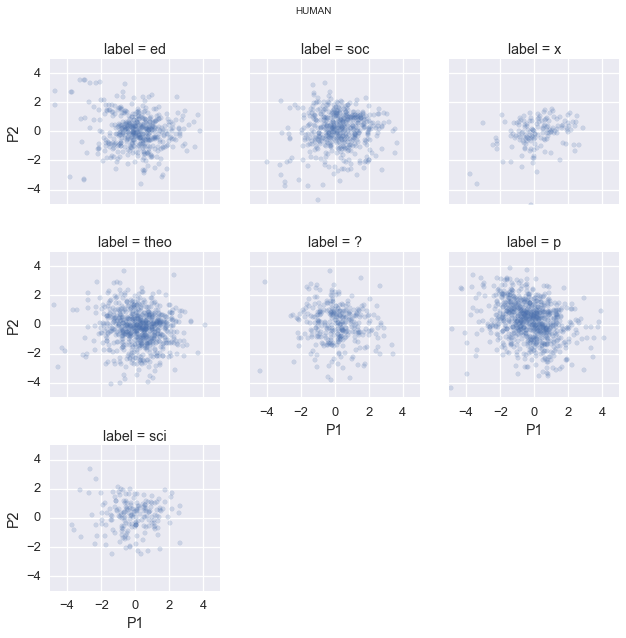

In [44]:
human_plot = sns.FacetGrid(philo, col='label', col_wrap = 3)
human_plot.map(plt.scatter, 'P1', 'P2', alpha=0.2)
human_plot.set(xlim=(-5,5), ylim=(-5,5))
plt.subplots_adjust(top=0.9)
human_plot.fig.suptitle('HUMAN')

This mostly shows that there's little detectable differentiation between the various subgenres of philosophy in 17-dimensional feature space.

### Human labels in Bokeh with interactivity

Here's the same thing, but plotted using Bokeh to give us interactivity. Note, too, that we're now leaving out 'x' and '?' types, for a bit of additional clarity.

The first plot here uses Bokeh's high-level plotting interface, which is really easy, but doesn't allow for the complex mouse-over information that we'll add in the second plot.

In [45]:
df = philo[(philo['label'] != '?') & (philo['label'] != 'x')]
p = Scatter(df, x='P1', y='P2', title="Human labels",
            xlabel="PC1", ylabel="PC2",
            color='label', legend='top_left')
show(p)

Now the same info, but using Bokeh's "mid-level" plotting API to add more complex mouse-over behavior, better color and alpha support, etc.

In [46]:
df['titl'] = df['title'].str.slice(0,40) # Short title info for mouseover

# Set up colormap
labels = df['label'].unique()
colors = Spectral5
colormap = {}
for i in range(len(labels)):
    colormap[labels[i]] = colors[i]
df['color'] = df['label'].map(lambda x: colormap[x])
data = ColumnDataSource(df)

hover = HoverTool(
        tooltips=[
            ("label", "@label"),
            ("author", "@auth"),
            ("title", "@titl"),
            ("year", "@year"),
        ]
    )
q = figure(title="Human labels",
            x_axis_label="PC1", y_axis_label="PC2")
q.circle('P1', 'P2', source=data,
         alpha=0.4, size=10, fill_color='color', line_color=None
        )
q.add_tools(hover)
show(q)

### _k_-Means labels

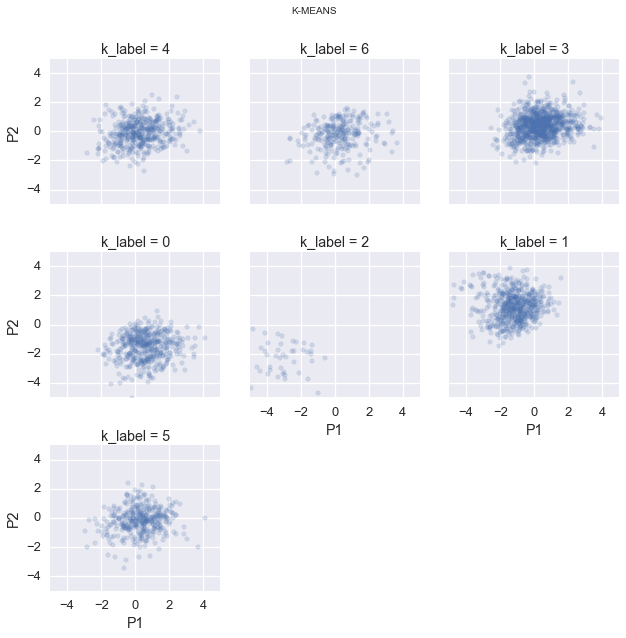

In [47]:
k_plot = sns.FacetGrid(philo, col='k_label', col_wrap = 3)
k_plot.map(plt.scatter, 'P1', 'P2', alpha=0.2)
k_plot.set(xlim=(-5,5), ylim=(-5,5))
plt.subplots_adjust(top=0.9)
k_plot.fig.suptitle('K-MEANS')

### DBSCAN labels

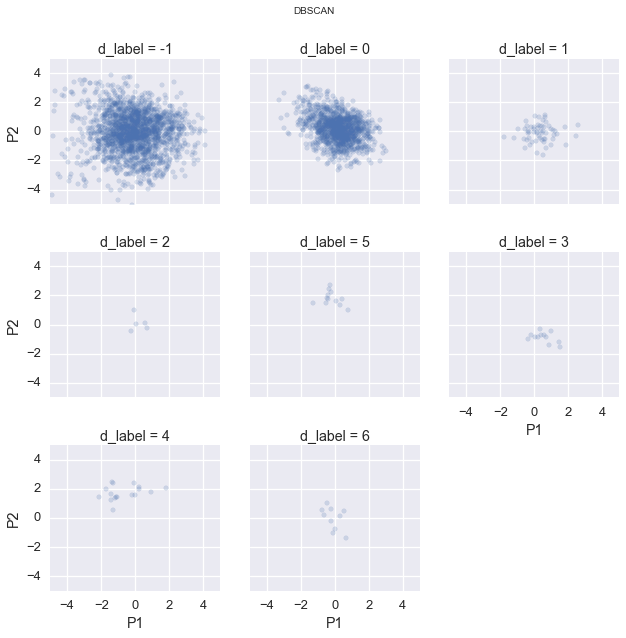

In [48]:
# DBSCAN
d_plot = sns.FacetGrid(philo, col='d_label', col_wrap = 3)
d_plot.map(plt.scatter, 'P1', 'P2', alpha=0.2)
d_plot.set(xlim=(-5,5), ylim=(-5,5))
plt.subplots_adjust(top=0.9)
d_plot.fig.suptitle('DBSCAN')

## To do

Things that one might try to improve these results:

* Perform grid search on DBSCAN to find best parameters. Currently non-optimal; see few large clusters and tendency to mark many as noise. 
* Dimensionality is very likely too high overall. Reduce feature space prior to clustering.
* Correlate human labels with machine labels. Maybe just by majority vote vs. human labels.
* Part of any future analytical work will involve examining the PCA loadings to see what's driving texts in certain directions.
* Extend the same analsysis to literary criticism, which is also part of the "Trace of Theory" project mandate.